In [1]:
## Imports: 
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats
import StatisticalMetrics as SM 
import readRthRaw as RTH 
import snrCalc as SNRC
import glob
import re
import os 
from shutil import copyfile
import math
import seaborn as sns
sns.set_context('talk')

ImportError: No module named 'seaborn'

# trackTest-18Apr2019

### Experiment Notes: 
In this experiment three electrophysiology catheters from the same manufacturer batch were placed in a fixture in a PAA phantom aligned along the main magnetic field. They were placed in two positions: near iso-centre, as well as at an off-isocentre position.

The full MR protocol is described [here](http://panoptes.sri.utoronto.ca:8090/confluence/display/IP/trackTest-18Apr2019+Catheter+Variance+Protocol)

Data stored at ircci-share/Data/track
	•	Full analysis done by Jay Soni

### Data Analysis
For simplicity, only the isocentre positions will be analysed. (Off-isocentre positions require a proprietary unwarping algorithm.)

### Localization Algorithms
Two custom algorithms from the Statistical Metrics module are run in the cells below.

In [15]:
temp_folder = "./test/" #A temporary folder directory for output. In on binder set this to "/tmp/"
!mkdir -p $temp_folder

In [16]:
ls $temp_folder

In [17]:
## Path/Constant variables:
#experiment_path = "trackTest-18Apr2019/"
experiment_path = temp_folder+"trackTest-18Apr2019/"
!mkdir $experiment_path
## this is a local directory, (used to reduce processing time) a global directory can be used as well: 
## experiment_path = "/volumes/ircci-share/data/trackTest-18Apr2019/"

catheters = ["cath284", "cath299", "cath285"]
positions = ["iso"]
sequences = ["fastHadamard", "SRI"]
algos = {"CentAlg1":SM.custm_centroid, "CentAlg4":SM.new_centroid_algorithm}
alg_params = {"CentAlg1":{"CoilLength":2.0,"Cutoff_value":0.5}, "CentAlg4":{"window_width":1}}
coil_label_patternSRI = ["cathcoil4", "cathcoil5"]
coil_label_patternFH = ["cathHVC4", "cathHVC5"]
projection_label_pattern = ["P0", "P1", "P2", "P3"]
dither_label_pattern = ["D0", "D1", "D2"]
fieldofview = ["fov60"] 

linearRecomb = [[-1,1,1,-1],[-1,1,-1,1],[-1,-1,1,1]]
linearRecomb = np.array(linearRecomb)
linearRecomb = (3**0.5/4.0)*linearRecomb

## Ground truth Coordinates: 
Off_Iso_Transform = [8.025, 0.0, -149.71]

coordinates_iso = [[[3.738, 5.541, 1.565], [3.70, 5.564, -6.205]],  ## Cath284  (mm)
                   [[6.638, 5.914, 2.940], [6.774, 6.028, -4.828]],  ## Cath299 (mm)
                   [[5.969, 6.055, 0.381], [5.929, 6.079, -7.389]]]  ## Cath285 (mm)
                        ## Distal (4)          Proximal (5)
    
coordinates_offiso = [[[11.763, 5.541, -148.145], [11.725, 5.564, -155.915]],  ## Cath284  (mm)
                      [[14.663, 5.914, -146.77], [14.799, 6.028, -154.538]],  ## Cath299 (mm)
                      [[13.994, 6.055, -149.329], [13.954, 6.079, -157.099]]]  ## Cath285 (mm)
                          ## Distal (4)             Proximal (5)
    
    
Ground_Truth = [coordinates_iso, coordinates_offiso]



In [18]:
!ls $temp_folder

trackTest-18Apr2019


In [19]:
!mkdir $experiment_path/WarpedCoordinates 

In [23]:
experiment_path

'./test/trackTest-18Apr2019/'

In [24]:
for seq in sequences:
    for cath in catheters: 
        for pos in positions: 
            if (seq == "SRI"): 
                path = experiment_path + seq + "/" + cath + "/" + 'SRI_Catheter_Tracking-' + pos + "/"
                in_path = "./trackTest-18Apr2019/"+ seq + "/" + cath + "/" + 'SRI_Catheter_Tracking-' + pos + "/"
                
                !mkdir -p $path 
                print(path)

                files = glob.glob(inpath+"cathcoil[4-5]*projections")
                for file in files: 
                    xsize,ysize,zsize,FOV,projNum,triggerTimes,respPhases,timestamps,projComplex = RTH.readProjections(file)
                    fts = RTH.reconstructProjections(projComplex,xsize,ysize)

                    file_suffix = (file.split("/"))[-1]
                    for alg in algos:
                        new_name = "warpedcoords" + alg + '-' + seq + "-" + cath + "-" + pos + "-" + (file_suffix.split("."))[0]

                        ## CentAlg1 : is the standard centroid algorithm with 
                        ##      window_scale 2.5 and cut off value at 0.5 

                        ## CentAlg2 : is the standard centroid algorithm with 
                        ##      window_scale 2.5 and cut off value at 0 

                        ## CentAlg3 : is the new centroid algorithm with 
                        ##      peak normed gaussian and width is 8 mm

                        ## CentAlg4 : is the new centroid algorithm with 
                        ##      peak normed gaussian and width is 1 mm

                        txt_file = open(experiment_path + "WarpedCoordinates/" + new_name + ".txt", 'w')

                        lst_of_vals = [[],[],[]]

                        for index, element in enumerate(fts):
                            parms = alg_params[alg]
                            parms["ProjectionFT"] = element
                            parms["FieldOfView"] = FOV
                            centroidInd, centroidCoord = algos[alg](**parms) 
                                                        #SM.new_centroid_algorithm(element, FOV, window_width=1)
                                                        #SM.custm_centroid(element, FOV, 2.0, Cutoff_value=0.5) 

                                                                           ## calculates coil position
                                                                            ## using centroid algorithm

                            lst_of_vals[index%3].append(centroidCoord)                               


                        for i in range(min(len(lst_of_vals[0]),len(lst_of_vals[1]),len(lst_of_vals[2]))):
                            txt_file.write("{} {} {} \n".format(lst_of_vals[0][i],lst_of_vals[1][i],lst_of_vals[2][i]))  
                                                                                  ## writes data to text file, 
                                                                                  ## first column = x-axis 
                                                                                  ## second column = y-axis
                                                                                  ## third column = z-axis                                                             
                        txt_file.close()

            else:
                path = experiment_path + seq + "/" + cath + "/" + 'fastHadamard_Tracking-' + pos + "/"
                inpath = "./trackTest-18Apr2019/"+ seq + "/" + cath + "/" + 'fastHadamard_Tracking-' + pos + "/"
                print(path)
                !mkdir -p $path 
                for alg in algos:
                    for coil_label in (coil_label_patternFH):
                        p0 = []
                        p1 = []
                        p2 = []
                        p3 = []
                        Projections = [p0,p1,p2,p3]
                        txt_file = open(experiment_path + "WarpedCoordinates/" + "warpedcoords" + alg + "-" + seq + "-" + cath + "-" + pos + "-" + coil_label + ".txt", 'w')

                        ## CentAlg1 : is the standard centroid algorithm with 
                        ##      window_scale 2.5 and cut off value at 0.5 

                        ## CentAlg2 : is the standard centroid algorithm with 
                        ##      window_scale 2.5 and cut off value at 0 

                        ## CentAlg3 : is the new centroid algorithm with 
                        ##      peak normed gaussian and width is 8 mm

                        ## CentAlg4 : is the new centroid algorithm with 
                        ##      peak normed gaussian and width is 1 mm

                        for projection_number, projection_label in enumerate(projection_label_pattern): 
                            fft = [[],[],[]]
                            pNum = [0,0,0]
                            FOVS = [0,0,0]

                            for dither_number, dither_label in enumerate(dither_label_pattern): 
                                file_name = (glob.glob(inpath + coil_label + projection_label + dither_label + "*.projections"))[0]

                                xsize,ysize,zsize,FOV,projNum,triggerTimes,respPhases,timestamps,projComplex = RTH.readProjections(file_name)
                                fts = RTH.reconstructProjections(projComplex,xsize,ysize)

                                fft[dither_number] = fts 
                                pNum[dither_number] = projNum
                                FOVS[dither_number] = FOV

                            for index in range(min(pNum)):
                                mag0 = abs(fft[0][index])
                                mag1 = abs(fft[1][index])
                                mag2 = abs(fft[2][index])

                                peak0 = max(mag0) 
                                peak1 = max(mag1)
                                peak2 = max(mag2)

                                dither = np.argmax(np.array([peak0,peak1,peak2]))
                                parms = alg_params[alg]
                                parms["ProjectionFT"] = fft[dither][index]
                                parms["FieldOfView"] = FOVS[dither]
                                centroidInd, centroidCoord = algos[alg](**parms) 
                                #centroidInd, centroidCoord = SM.new_centroid_algorithm(fft[dither][index], FOVS[dither], window_width=1)
                                                            #SM.custm_centroid(fft[dither][index], FOVS[dither], 2.0, Cutoff_value=0.5)

                                                                                ## calculates coil position
                                                                                ## using centroid algorithm

                                Projections[projection_number].append(centroidCoord)


                        for i in range(min(len(p0), len(p1), len(p2), len(p3))):
                            projection_array = np.array([[p0[i]], [p1[i]], [p2[i]], [p3[i]]])
                            coords = np.dot(linearRecomb, projection_array)

                            txt_file.write("{} {} {} \n".format(float(coords[0]),float(coords[1]),float(coords[2])))  


                        txt_file.close()

print("Done Copying!")

./test/trackTest-18Apr2019/fastHadamard/cath284/fastHadamard_Tracking-iso/
./test/trackTest-18Apr2019/fastHadamard/cath299/fastHadamard_Tracking-iso/
./test/trackTest-18Apr2019/fastHadamard/cath285/fastHadamard_Tracking-iso/
./test/trackTest-18Apr2019/SRI/cath284/SRI_Catheter_Tracking-iso/
./test/trackTest-18Apr2019/SRI/cath299/SRI_Catheter_Tracking-iso/
./test/trackTest-18Apr2019/SRI/cath285/SRI_Catheter_Tracking-iso/
Done Copying!


In [26]:
glob.glob(inpath + coil_label + projection_label + dither_label + "*.projections")

['./trackTest-18Apr2019/fastHadamard/cath285/fastHadamard_Tracking-iso/cathHVC5P3D2-0000.projections']

In [27]:
path

'./test/trackTest-18Apr2019/SRI/cath285/SRI_Catheter_Tracking-iso/'

In [28]:
ls $path

In [30]:
!ls $path/trackTest-18Apr2019/WarpedCoordinates/

ls: 无法访问./test/trackTest-18Apr2019/SRI/cath285/SRI_Catheter_Tracking-iso//trackTest-18Apr2019/WarpedCoordinates/: 没有那个文件或目录


#### Unwarping not performed

The coil coordinates which have been saved to the WarpedCoordinates folder could have potentially fallen victim to gradient warping and should be unwarped, however the unwarping code is not available outside of SRI. Only near-isocentre positions will be analysed.

In [31]:
## This bit of code copys the unwarped coordinates for each coil and places them in the correct folder so they can be easily
## accessed for future use. 
counter = 0

for seq in sequences:
    for cath in catheters: 
        for pos in positions:
            for alg in algos:
                if (seq == "SRI"): 
                    path = experiment_path + seq + "/" + cath + "/" + 'SRI_Catheter_Tracking-' + pos + "/"
                    path_warped = experiment_path + "WarpedCoordinates/"

                    files = glob.glob(path_warped + "warpedcoords" + alg + "-" + seq + "-" + cath + "-" + pos + "-cathcoil*.txt")

                    for file in files: 
                        name = (file.split("/"))[-1]
                        copyfile(file, path + name)     
                        counter += 1

                else:
                    path = experiment_path + seq + "/" + cath + "/" + 'fastHadamard_Tracking-' + pos + "/"
                    path_warped = experiment_path + "WarpedCoordinates/"

                    file1_name = "warpedcoords" + alg + "-" + seq + "-" + cath + "-" + pos + "-" + "cathHVC4.txt"
                    file1_copy = "warpedcoords" + alg + "-" + seq + "-" + cath + "-" + pos + "-" + "cathHVC4-warp.txt"
                    file2_name = "warpedcoords" + alg + "-" + seq + "-" + cath + "-" + pos + "-" + "cathHVC5.txt"
                    file2_copy = "warpedcoords" + alg + "-" + seq + "-" + cath + "-" + pos + "-" + "cathHVC5-warp.txt"


                    copyfile(path_warped + file1_name, path + file1_copy)
                    copyfile(path_warped + file2_name, path + file2_copy)
                    counter += 2

print("Done Copying!")
print(counter)

Done Copying!
12


fastHadamard cath284 isoError 1.8362417650080063, Std 1.9025236864754733, n = 111 

fastHadamard cath299 isoError 1.9586865828963325, Std 1.7490401710758607, n = 106 

fastHadamard cath285 isoError 1.880617524109443, Std 1.7279333642165393, n = 108 

SRI cath284 isoError nan, Std nan, n = 108 

SRI cath299 isoError nan, Std nan, n = 108 

SRI cath285 isoError nan, Std nan, n = 108 

[nan, nan, nan]


/share/apps/python3/3.5.3/intel/lib/python3.5/site-packages/numpy-1.12.0-py3.5-linux-x86_64.egg/numpy/core/fromnumeric.py:2889: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/share/apps/python3/3.5.3/intel/lib/python3.5/site-packages/numpy-1.12.0-py3.5-linux-x86_64.egg/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/share/apps/python3/3.5.3/intel/lib/python3.5/site-packages/numpy-1.12.0-py3.5-linux-x86_64.egg/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/share/apps/python3/3.5.3/intel/lib/python3.5/site-packages/numpy-1.12.0-py3.5-linux-x86_64.egg/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/share/apps/python3/3.5.3/intel/lib/python3.5/site-packages/numpy-1.12.0-py3.5-linux-x86_64.egg/numpy/core/_methods.py:127: RuntimeWarning: invalid value e

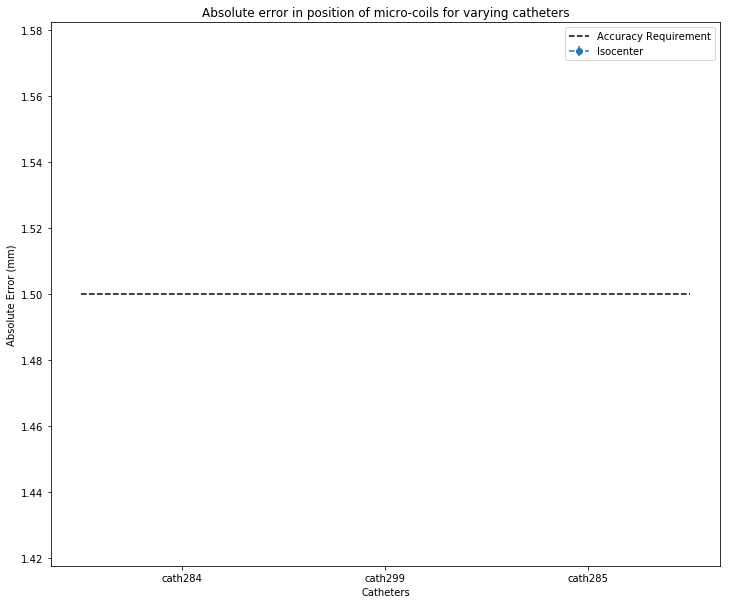

Done!


In [32]:
SRI_iso_error = [[], ## cath284
                 [], ## cath299
                 []] ## cath285

Fh_iso_error =  [[], ## cath284
                 [], ## cath299
                 []] ## cath285

Data_Array = [[Fh_iso_error], #FH 
              [SRI_iso_error]] #SRI  

SRI_iso =       [[], ## cath284
                 [], ## cath299
                 []] ## cath285

Fh_iso =        [[], ## cath284
                 [], ## cath299
                 []] ## cath285

Data_Array2 = [[Fh_iso],  #FH 
               [SRI_iso]]   # SRI

for SIndex, seq in enumerate(sequences): 
    for CIndex, cath in enumerate(catheters): 
        for PIndex, pos in enumerate(positions): 
            
            if (seq == "fastHadamard"):
                path = experiment_path + seq + "/" + cath + "/" + 'fastHadamard_Tracking-' + pos + "/"
            elif (seq == 'SRI'): 
                path = experiment_path + seq + "/" + cath + "/" + 'SRI_Catheter_Tracking-' + pos + "/"
                
            files = glob.glob(path + "warpedcoordsCentAlg4*.txt")
            
            X_coord = []
            Y_coord = []
            Z_coord = []
            
            for file in files: 

                
                file_suffix1 = (((file.split("/"))[-1]).split("-"))[-2] ## cathcoil#      two different file name types 
                file_suffix2 = (((file.split("/"))[-1]).split("-"))[-2] ## cathHVC#      need to  be seperated to determine coil number! 
            
                if((file_suffix2 == "cathHVC4") or (file_suffix1 == "cathcoil4")): 
                    true_position = Ground_Truth[PIndex][CIndex][0] 

                elif((file_suffix2 == "cathHVC5") or (file_suffix1 == "cathcoil5")): 
                    true_position = Ground_Truth[PIndex][CIndex][1]
                
                else: 
                    raise Exception('Error could not find suffix! : {}'.format(file))
                
                X_truth = true_position[0]
                Y_truth = true_position[1]
                Z_truth = true_position[2]
                
                file_coords = open(file, 'r')
                experiment_info = file_coords.readlines()
                file_coords.close()
                
                for line in experiment_info:
                    experimental_coords = (line.split(" ")) 
                    X_coord.append(float(experimental_coords[0]) - X_truth)
                    Y_coord.append(float(experimental_coords[1]) - Y_truth)
                    Z_coord.append(float(experimental_coords[2]) - Z_truth)
            
            X_coord_mean = np.mean(X_coord)
            Y_coord_mean = np.mean(Y_coord)
            Z_coord_mean = np.mean(Z_coord)

            X_std = np.std(X_coord)
            Y_std = np.std(Y_coord)
            Z_std = np.std(Z_coord)

            Std = ((X_std)**2 + (Y_std)**2 + (Z_std)**2)**(1/2)

            Error = ((X_coord_mean)**2 + (Y_coord_mean)**2 + (Z_coord_mean)**2)**(1/2)

            Data_Array[SIndex][PIndex][CIndex].append(Error)
            Data_Array[SIndex][PIndex][CIndex].append(Std)
            Data_Array2[SIndex][PIndex][CIndex].append(X_coord)
            Data_Array2[SIndex][PIndex][CIndex].append(Y_coord)
            Data_Array2[SIndex][PIndex][CIndex].append(Z_coord)

            print(seq + ' ' + cath + ' ' + pos + 'Error {}, Std {}, n = {} \n'.format(Error, Std, len(experiment_info)))

            
Iso_error = [SRI_iso_error[0][0], SRI_iso_error[1][0], SRI_iso_error[2][0]] 
Iso_std = [SRI_iso_error[0][1], SRI_iso_error[1][1], SRI_iso_error[2][1]]

print(Iso_error)
hori_axis = np.array([0.5, 1.5, 2.5])

plt.figure(figsize=(12,10))
plt.title("Absolute error in position of micro-coils for varying catheters")
plt.ylabel("Absolute Error (mm)")
plt.xlabel("Catheters")
plt.errorbar(hori_axis, Iso_error, yerr = Iso_std, fmt = "--o", label = 'Isocenter')
#plt.errorbar(hori_axis, Off_error, yerr = Off_std, fmt = "--^", label = 'Off-isocenter')
plt.hlines(1.5, 0, 3, linestyles='dashed', label='Accuracy Requirement')
plt.legend()
plt.xticks(hori_axis, catheters)
plt.show()
        
print('Done!')

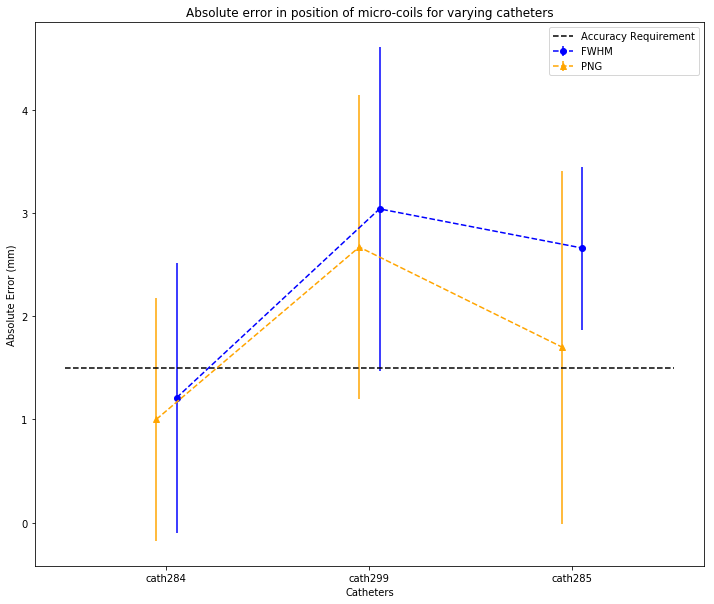

In [33]:
## temp copy paste to graph multiple algorithms on same chart 

SRI_iso_PNG_error = [1.00, 2.67, 1.70]           ## Cath284, Cath299, Cath285
SRI_iso_PNG_std = [1.18, 1.47, 1.71] 

SRI_iso_FWHM_error = [1.21, 3.04, 2.66]          ## Cath284, Cath299, Cath285
SRI_iso_FWHM_std = [1.31, 1.57, 0.79] 

hori_axis = np.array([1,2,3])

plt.figure(figsize=(12,10))
plt.title("Absolute error in position of micro-coils for varying catheters")
plt.ylabel("Absolute Error (mm)")
plt.xlabel("Catheters")
plt.errorbar(hori_axis + 0.55, SRI_iso_FWHM_error, yerr = SRI_iso_FWHM_std, color = 'blue', fmt = "--o", label = 'FWHM')
plt.errorbar(hori_axis + 0.45, SRI_iso_PNG_error, yerr = SRI_iso_PNG_std, color = 'orange', fmt = "--^", label = 'PNG')
plt.hlines(1.5, 1, 4, linestyles='dashed', label='Accuracy Requirement')
plt.legend()
plt.xticks(hori_axis + 0.5, catheters)
plt.show()